In [1]:
import sys
import os
import importlib

# Add the /models directory to sys.path
sys.path.append(os.path.abspath("../models"))

# Force reload tspb_model module to reflect latest changes
if 'tspb_model' in sys.modules:
    importlib.reload(sys.modules['tspb_model'])
else:
    import tspb_model

# Import all updated functions
from tspb_model import (
    load_yard_parameters,
    load_link_parameters,
    load_od_demands,
    compute_shortest_paths,
    solve_path_model,
    solve_block_model_with_distance_penalty
)


In [2]:
import sys
import os
import pandas as pd
# Add the /models directory to import tspb_model.py
sys.path.append(os.path.abspath("../models"))

from tspb_model import load_yard_parameters, load_link_parameters, load_od_demands, compute_shortest_paths, solve_path_model

# === Setup file paths ===
base_path = "../data"
yard_file = os.path.join(base_path, "DataSet_2_Yard Parameter.xlsx")
link_file = os.path.join(base_path, "DataSet_2_Link parameter.xlsx")
od_file = os.path.join(base_path, "DataSet_2_OD.xlsx")

# === DEBUG PRINTS: Check actual column names ===
print("🔍 Yard File Columns:")
yard_df = pd.read_excel(yard_file)
print(yard_df.columns.tolist())

print("\n🔍 Link File Columns:")
link_df = pd.read_excel(link_file)
print(link_df.columns.tolist())

print("\n🔍 OD File Columns:")
od_df = pd.read_excel(od_file)
print(od_df.columns.tolist())

# === Load cleaned data using tspb_model.py ===
yard_info = load_yard_parameters(yard_file)
G1 = load_link_parameters(link_file)
od_pairs = load_od_demands(od_file)

# === Compute shortest paths (shipment path subproblem) ===
shortest_paths, shortest_lengths = compute_shortest_paths(G1, od_pairs)

# Solve the PATH subproblem
print("\n🚀 Solving shipment path model...")
objective_value, selected_paths = solve_path_model(G1, od_pairs, shortest_lengths)

# Show results
print(f"\n✅ Optimal car-km cost: {objective_value:.2f}")
print("\n✅ Sample selected edge paths (first 5):")
for k, edges in list(selected_paths.items())[:5]:
    print(f"{k}: {edges}")

# === Preview ===
print("\n✅ Sample Yard Info:")
print(list(yard_info.items())[:2])

print("\n✅ Sample OD Paths:")
print(list(shortest_paths.items())[:5])


🔍 Yard File Columns:
['No.', 'Yard', 'RC', 'ST', 'COST', 'AP']

🔍 Link File Columns:
['No.', 'NodeA', 'NodeB', 'CapaAB', 'Length']

🔍 OD File Columns:
['YARD', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08', 'Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16']

🚀 Solving shipment path model...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2689268
Academic license 2689268 - for non-commercial use only - registered to vj___@uwaterloo.ca

✅ Optimal car-km cost: 12409414.00

✅ Sample selected edge paths (first 5):
('Y01', 'Y02'): [('Y01', 'Y02')]
('Y01', 'Y03'): [('Y01', 'Y02'), ('Y02', 'Y03')]
('Y01', 'Y04'): [('Y01', 'Y02'), ('Y02', 'Y03'), ('Y03', 'Y04')]
('Y01', 'Y05'): [('Y01', 'Y05')]
('Y01', 'Y06'): [('Y01', 'Y02'), ('Y02', 'Y06')]

✅ Sample Yard Info:
[('Y01', {'reclass_delay': 422, 'capacity': 4.2, 'sort_tracks': 14, 'beta': 10.8}), ('Y02', {'reclass_delay': 129, 'capacity': 3.92, 'sort_tracks': 18, 'beta': 10.5})]

✅ Sample OD Paths

In [3]:
print("\n🚆 Solving train blocking model (strict yard capacity)...")

try:
    blocking_cost, block_assignments, blocks_built, _ = solve_block_model_with_distance_penalty(
        yard_info,
        od_pairs,
        selected_paths,
        shortest_lengths, 
        strict_capacity=True
    )
    print("\n✅ Used strict yard capacity.")
except RuntimeError as e:
    print(f"\n❌ Blocking model failed to solve: {e}")



🚆 Solving train blocking model (strict yard capacity)...

🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard

In [6]:
from tqdm import tqdm
import random

print("\n🔁 Running experiments across random OD demand scenarios...")

num_trials = 20
successful_trials = 0
failed_trials = 0

trial_results = []

for trial_num in tqdm(range(num_trials), desc="Trials"):
    randomized_od = []

    for o, d, cars in od_pairs:
        new_cars = max(0, int(random.gauss(cars, cars * 0.1)))
        if new_cars > 0:
            randomized_od.append((o, d, new_cars))

    try:
        # === Step 1: Shipment path model ===
        sp_obj, trial_paths = solve_path_model(G1, randomized_od, shortest_lengths)

        # === Step 2: Train blocking model (strict capacity only) ===
        blk_obj, trial_blocks, trial_built, _ = solve_block_model_with_distance_penalty(
            yard_info,
            randomized_od,
            trial_paths,
            shortest_lengths,  # ✅ REQUIRED for distance penalty computation
            strict_capacity=True
        )
        print(f"✅ Trial {trial_num}: Blocking model succeeded.")

        trial_results.append({
            'trial': trial_num,
            'sp_obj': sp_obj,
            'blk_obj': blk_obj,
            'paths': trial_paths,
            'blocks': trial_blocks,
            'built': trial_built 
        })
        successful_trials += 1

    except RuntimeError as e:
        print(f"❌ Trial {trial_num}: Blocking model failed - {e}")
        failed_trials += 1

print("\n📊 Summary:")
print(f"✅ Successful trials: {successful_trials}")
print(f"❌ Failed trials: {failed_trials}")


🔁 Running experiments across random OD demand scenarios...


Trials:   5%|███▊                                                                       | 1/20 [00:01<00:26,  1.37s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  10%|███████▌                                                                   | 2/20 [00:02<00:22,  1.26s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  15%|███████████▎                                                               | 3/20 [00:03<00:21,  1.27s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  20%|███████████████                                                            | 4/20 [00:05<00:19,  1.24s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  25%|██████████████████▊                                                        | 5/20 [00:06<00:18,  1.25s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  30%|██████████████████████▌                                                    | 6/20 [00:07<00:16,  1.19s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  35%|██████████████████████████▎                                                | 7/20 [00:08<00:14,  1.14s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  40%|██████████████████████████████                                             | 8/20 [00:09<00:14,  1.17s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  45%|█████████████████████████████████▊                                         | 9/20 [00:10<00:12,  1.18s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  50%|█████████████████████████████████████                                     | 10/20 [00:11<00:11,  1.17s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  55%|████████████████████████████████████████▋                                 | 11/20 [00:13<00:10,  1.15s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  60%|████████████████████████████████████████████▍                             | 12/20 [00:14<00:09,  1.18s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  65%|████████████████████████████████████████████████                          | 13/20 [00:15<00:08,  1.18s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  70%|███████████████████████████████████████████████████▊                      | 14/20 [00:16<00:06,  1.15s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  75%|███████████████████████████████████████████████████████▌                  | 15/20 [00:17<00:05,  1.16s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  80%|███████████████████████████████████████████████████████████▏              | 16/20 [00:18<00:04,  1.14s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  85%|██████████████████████████████████████████████████████████████▉           | 17/20 [00:20<00:03,  1.18s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  90%|██████████████████████████████████████████████████████████████████▌       | 18/20 [00:21<00:02,  1.37s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials:  95%|██████████████████████████████████████████████████████████████████████▎   | 19/20 [00:23<00:01,  1.45s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

Trials: 100%|██████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

📊 Summary Statistics:
          trial  shipment_cost  blocking_cost    total_cost
count  20.00000   2.000000e+01   2.000000e+01  2.000000e+01
mean    9.50000   1.237596e+07   7.960898e+06  2.033686e+07
std     5.91608   9.345431e+04   4.111602e+04  1.285219e+05
min     0.00000   1.221112e+07   7.901132e+06  2.011225e+07
25%     4.75000   1.233736e+07   7.936782e+06  2.028051e+07
50%     9.50000   1.237088e+07   7.959929e+06  2.033625e+07
75%    14.25000   1.242665e+07   7.980250e+06  2.038828e+07
max    19.00000   1.259477e+07   8.063117e+06  2.061660e+07

📈 Pearson Correlation (Shipment vs Blocking Cost): 0.7929 (p = 3.048e-05)


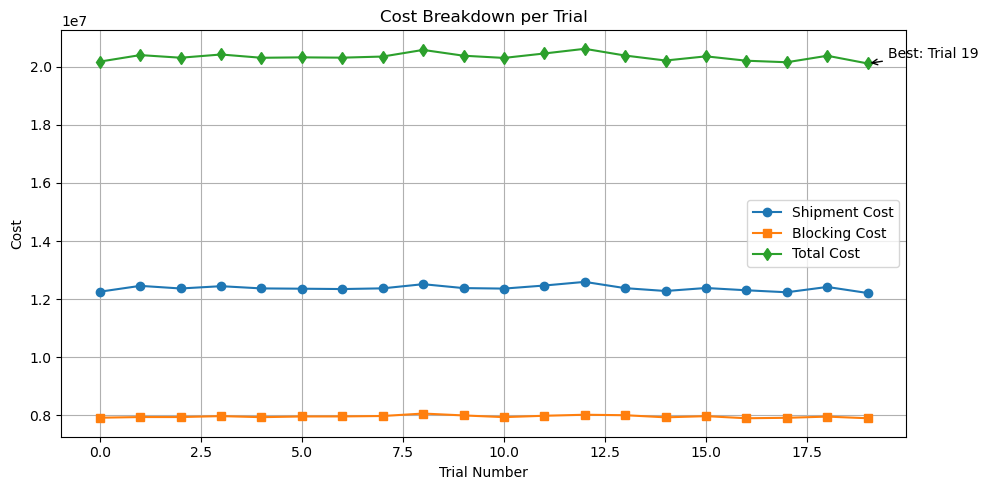

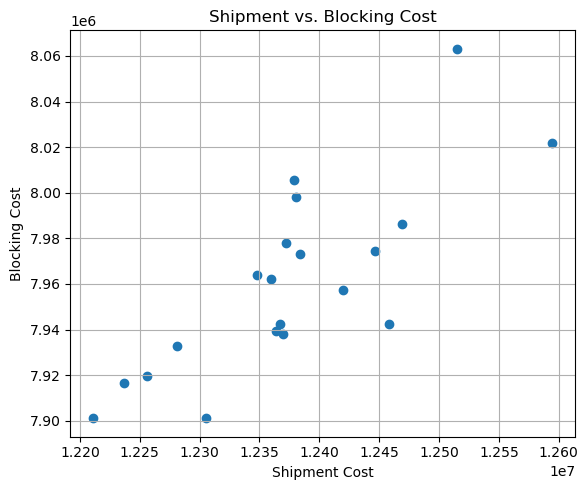

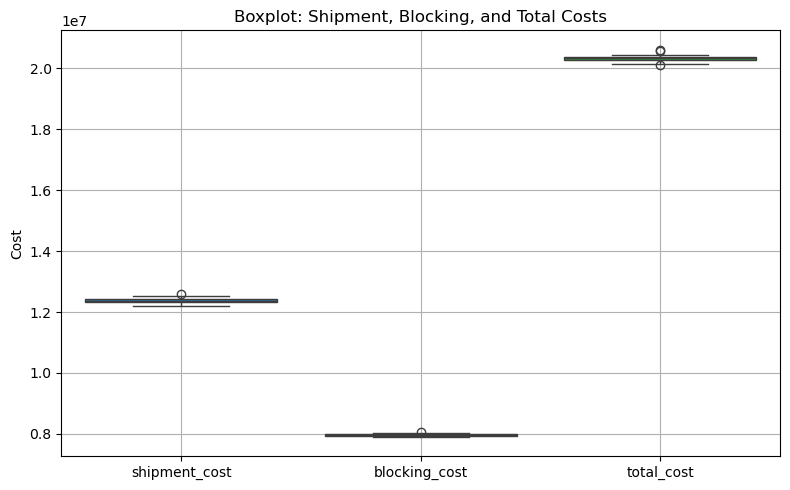

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# Convert trial results to DataFrame
df = pd.DataFrame(trial_results)

# Rename for clarity
df = df.rename(columns={'sp_obj': 'shipment_cost', 'blk_obj': 'blocking_cost'})

# Compute total cost
df['total_cost'] = df['shipment_cost'] + df['blocking_cost']

# Summary stats
print("📊 Summary Statistics:")
print(df.describe())

# Check for constant column before computing correlation
if df['shipment_cost'].nunique() == 1 or df['blocking_cost'].nunique() == 1:
    print("\n⚠️ Pearson Correlation not computed: One of the cost columns is constant.")
else:
    corr, p_val = pearsonr(df['shipment_cost'], df['blocking_cost'])
    print(f"\n📈 Pearson Correlation (Shipment vs Blocking Cost): {corr:.4f} (p = {p_val:.4g})")

# Plot: Cost Breakdown per Trial
plt.figure(figsize=(10, 5))
plt.plot(df['trial'], df['shipment_cost'], marker='o', label='Shipment Cost')
plt.plot(df['trial'], df['blocking_cost'], marker='s', label='Blocking Cost')
plt.plot(df['trial'], df['total_cost'], marker='d', label='Total Cost')

# Highlight best trial
best_idx = df['total_cost'].idxmin()
best_trial = df.loc[best_idx]
plt.annotate(
    f"Best: Trial {int(best_trial['trial'])}",
    xy=(best_trial['trial'], best_trial['total_cost']),
    xytext=(best_trial['trial'] + 0.5, best_trial['total_cost'] + 2e5),
    arrowprops=dict(facecolor='green', arrowstyle='->')
)

plt.title("Cost Breakdown per Trial")
plt.xlabel("Trial Number")
plt.ylabel("Cost")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Shipment vs Blocking Cost Scatter
plt.figure(figsize=(6, 5))
plt.scatter(df['shipment_cost'], df['blocking_cost'])
plt.title("Shipment vs. Blocking Cost")
plt.xlabel("Shipment Cost")
plt.ylabel("Blocking Cost")
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot for distributions
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['shipment_cost', 'blocking_cost', 'total_cost']])
plt.title("Boxplot: Shipment, Blocking, and Total Costs")
plt.ylabel("Cost")
plt.grid(True)
plt.tight_layout()
plt.show()


Current Working Directory: C:\Users\notva\Downloads\MSCI434_Project\notebooks

🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y1

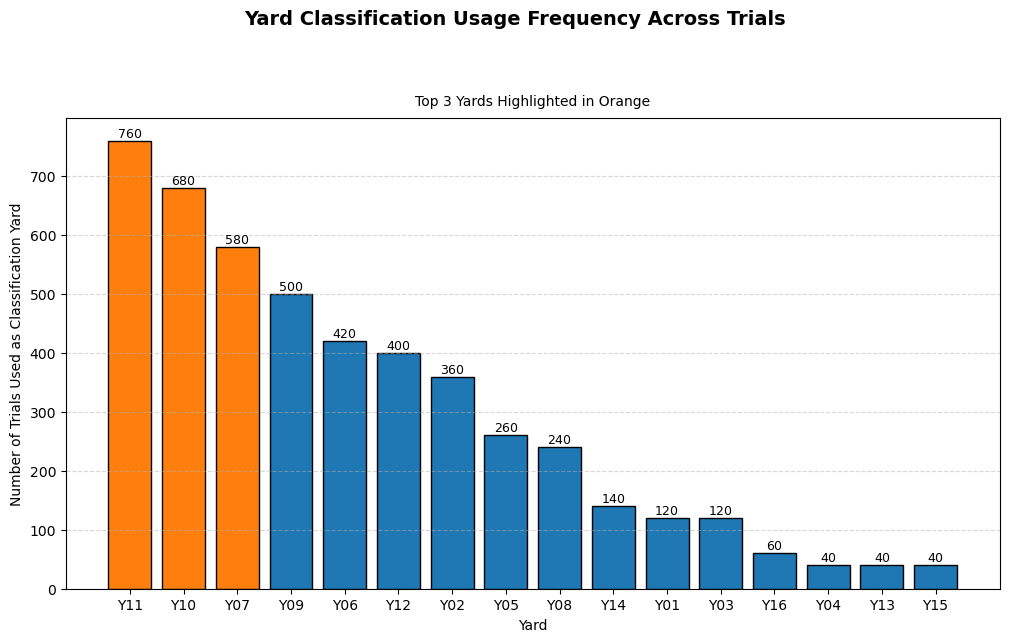

📊 Top 10 Classification Yards:
  Yard  UsageCount
0  Y11         760
1  Y10         680
2  Y07         580
3  Y09         500
4  Y06         420
5  Y12         400
6  Y02         360
7  Y05         260
8  Y08         240
9  Y14         140


In [21]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import GRB
import networkx as nx

# Add the model path
sys.path.append("../models")

from tspb_model import (
    load_yard_parameters,
    load_link_parameters,
    load_od_demands,
    compute_shortest_paths,
    solve_path_model,
    solve_block_model_with_distance_penalty
)

# === Setup file paths ===
base_path = "../data"
yard_file = os.path.join(base_path, "DataSet_2_Yard Parameter.xlsx")
link_file = os.path.join(base_path, "DataSet_2_Link parameter.xlsx")
od_file = os.path.join(base_path, "DataSet_2_OD.xlsx")

print("Current Working Directory:", os.getcwd())

# 1. Load the data
yard_info = load_yard_parameters(yard_file)
G = load_link_parameters(link_file)
od_pairs = load_od_demands(od_file)

# 2. Compute shortest paths
shortest_paths, shortest_lengths = compute_shortest_paths(G, od_pairs)

# 3. Run multiple trials with strict yard capacity
num_trials = 20
all_block_assignments = []

for trial_num in range(num_trials):
    try:
        _, selected_paths = solve_path_model(G, od_pairs, shortest_lengths)
        _, block_assignment, _, _ = solve_block_model_with_distance_penalty(
        yard_info, od_pairs, selected_paths, shortest_lengths,
        strict_capacity=True
    )
        all_block_assignments.append(block_assignment)
    except RuntimeError:
        print(f"❌ Trial {trial_num} failed and was skipped.")

# 4. Count yard usage
yard_usage = {}
for trial_blocks in all_block_assignments:
    for yards in trial_blocks.values():
        for yard in yards:
            yard_usage[yard] = yard_usage.get(yard, 0) + 1

# 5. Plot
yard_usage_df = pd.DataFrame(list(yard_usage.items()), columns=["Yard", "UsageCount"])
yard_usage_df = yard_usage_df.sort_values(by="UsageCount", ascending=False).reset_index(drop=True)
top_3 = yard_usage_df.iloc[:3]["Yard"].tolist()
colors = ["#1f77b4" if yard not in top_3 else "#ff7f0e" for yard in yard_usage_df["Yard"]]

plt.figure(figsize=(10, 6))
bars = plt.bar(yard_usage_df["Yard"], yard_usage_df["UsageCount"], color=colors, edgecolor="black")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{int(height)}", ha="center", va="bottom", fontsize=9)

plt.suptitle("Yard Classification Usage Frequency Across Trials", fontsize=14, weight='bold', y=1.03)
plt.title("Top 3 Yards Highlighted in Orange", fontsize=10, y=1.01)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.xlabel("Yard")
plt.ylabel("Number of Trials Used as Classification Yard")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

print("📊 Top 10 Classification Yards:")
print(yard_usage_df.head(10))


In [12]:
num_trials = 20
trial_results = []

for trial_num in range(num_trials):
    try:
        sp_obj, selected_paths = solve_path_model(G, od_pairs, shortest_lengths)
        blk_obj, block_assignment, blocks_built, _ = solve_block_model_with_distance_penalty(
            yard_info, od_pairs, selected_paths, shortest_lengths,
            strict_capacity=True
        )

        trial_results.append({
            "trial_num": trial_num,
            "sp_obj": sp_obj if sp_obj is not None else 0,
            "blk_obj": blk_obj,
            "paths": selected_paths,
            "assignment": block_assignment,
            "built": blocks_built
        })

    except RuntimeError:
        print(f"❌ Trial {trial_num} failed and was skipped.")



🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified at yard Y10
  - Y02 → Y10 classified at yard Y06
  - Y02 → Y11 classified at yard Y07
  - Y02 → Y12 cl

✅ Trials with valid cost: 20 / 20


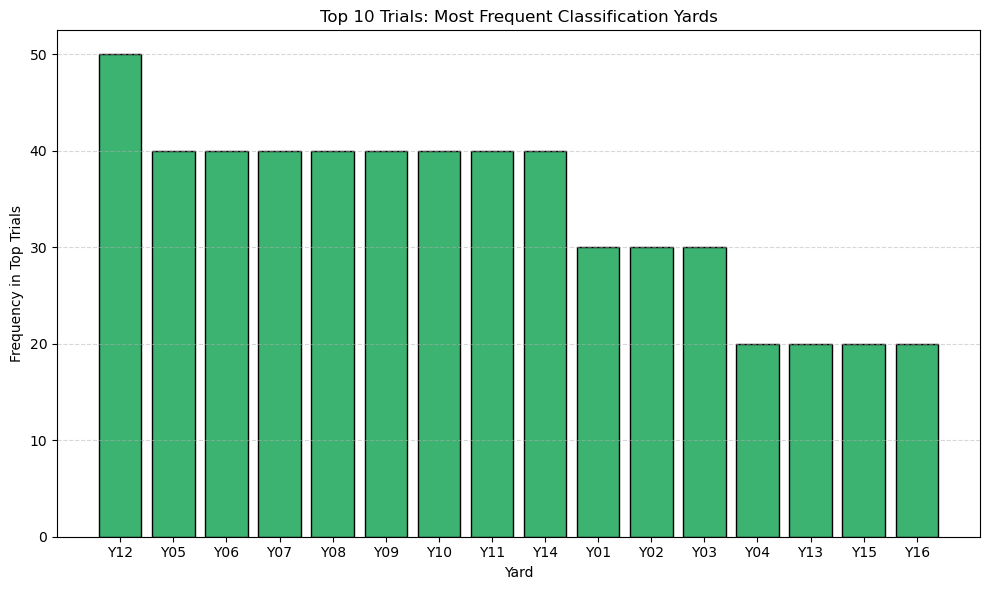

📦 Top Shipment Paths in Top 10 Trials:


,Path,Count
0,"((Y01, Y02),)",10
1,"((Y11, Y15),)",10
2,"((Y06, Y02), (Y07, Y06), (Y11, Y07))",10
3,"((Y07, Y03), (Y11, Y07))",10
4,"((Y07, Y08), (Y08, Y04), (Y11, Y07))",10
5,"((Y09, Y05), (Y10, Y09), (Y11, Y10))",10
6,"((Y07, Y06), (Y11, Y07))",10
7,"((Y11, Y07),)",10
8,"((Y07, Y08), (Y11, Y07))",10
9,"((Y10, Y09), (Y11, Y10))",10


In [13]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

top_n = 10

# --- Step 1: Sort by total cost (sp_obj + blk_obj) ---
valid_trials = [
    trial for trial in trial_results
    if isinstance(trial.get("sp_obj"), (int, float)) and isinstance(trial.get("blk_obj"), (int, float))
]
top_trials = sorted(valid_trials, key=lambda x: x["sp_obj"] + x["blk_obj"])[:top_n]

print(f"✅ Trials with valid cost: {len(valid_trials)} / {len(trial_results)}")

# --- Step 2: Aggregate Classification Yard Usage ---
top_yard_usage = Counter()
for trial in top_trials:
    for built in trial['built']:
        built_yard_info = built[0]  # renamed to avoid clobbering global yard_info
        yard_name = built_yard_info if not isinstance(built_yard_info, tuple) else built_yard_info[0]
        top_yard_usage[yard_name] += 1

top_yard_df = pd.DataFrame(top_yard_usage.items(), columns=["Yard", "UsageCount"]) \
                 .sort_values(by="UsageCount", ascending=False).reset_index(drop=True)

# --- Step 3: Aggregate Shipment Paths ---
top_path_usage = Counter()
for trial in top_trials:
    for od_pair, path in trial['paths'].items():
        top_path_usage[tuple(path)] += 1

top_paths_df = pd.DataFrame(top_path_usage.items(), columns=["Path", "Count"]) \
                  .sort_values(by="Count", ascending=False).reset_index(drop=True)

# --- Step 4: Visualization ---
plt.figure(figsize=(10, 6))
plt.bar(top_yard_df["Yard"], top_yard_df["UsageCount"], color='mediumseagreen', edgecolor='black')
plt.title(f"Top {top_n} Trials: Most Frequent Classification Yards")
plt.xlabel("Yard")
plt.ylabel("Frequency in Top Trials")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Step 5: Print Top Paths Table ---
print(f"📦 Top Shipment Paths in Top {top_n} Trials:")
display(top_paths_df.head(10))


In [15]:
import json

# Recursive function to stringify all dict keys in any nested structure
def stringify_keys_recursive(obj):
    if isinstance(obj, dict):
        return {str(k): stringify_keys_recursive(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [stringify_keys_recursive(v) for v in obj]
    elif isinstance(obj, tuple):
        return tuple(stringify_keys_recursive(v) for v in obj)
    else:
        return obj

# Build exportable summary list
top_trials_export = []
for i, trial in enumerate(top_trials):
    trial_data = {
        "trial_index": i,
        "shipment_paths": stringify_keys_recursive(trial["paths"]),
        "blocks": stringify_keys_recursive(trial["assignment"]),
        "built": stringify_keys_recursive(trial["built"])
    }
    top_trials_export.append(trial_data)

# Export JSON
with open("top_trials_summary.json", "w") as f:
    json.dump(top_trials_export, f, indent=2)

# Export CSVs
top_yard_df.to_csv("top_yard_usage.csv", index=False)
top_paths_df.to_csv("top_shipment_paths.csv", index=False)

print("✅ Export complete: 'top_trials_summary.json', 'top_yard_usage.csv', and 'top_shipment_paths.csv'")


✅ Export complete: 'top_trials_summary.json', 'top_yard_usage.csv', and 'top_shipment_paths.csv'


In [16]:
print("✅ Debug yard_info type check")
print("Type:", type(yard_info))
try:
    print("Sample:", list(yard_info.items())[:1])
except Exception as e:
    print("❌ Error:", e)


✅ Debug yard_info type check
Type: <class 'dict'>
Sample: [('Y01', {'reclass_delay': 422, 'capacity': 4.2, 'sort_tracks': 14, 'beta': 10.8})]


In [18]:
def generate_initial_feasible_solution(block_assignment, blocks_built):
    """
    Converts a feasible solution (from prior run) into a warm start format
    for Gurobi. Returns a dictionary with keys matching variable names.
    """
    init_sol = {}

    # Add z[o,d,k] values
    for (o, d), yards in block_assignment.items():
        for k in yards:
            init_sol[(o, d, k)] = 1

    # Add y[k,d] values
    for (k, d) in blocks_built:
        init_sol[("y", k, d)] = 1

    return init_sol


In [19]:
import time

# Step 1: Solve shipment paths (if not already solved)
_, selected_paths = solve_path_model(G, od_pairs, shortest_lengths)

# Step 2: Solve blocking model normally (no warm start)
start1 = time.time()
assert isinstance(yard_info, dict), f"yard_info should be a dictionary, but got: {type(yard_info)}"
print("yard_info sample:", list(yard_info.items())[:1])
obj1, blocks1, built1, _ = solve_block_model_with_distance_penalty(
    yard_info, od_pairs, selected_paths, shortest_lengths,
    strict_capacity=True
)
end1 = time.time()

# Step 3: Generate initial solution from previous result
initial_solution = generate_initial_feasible_solution(blocks1, built1)

# Step 4: Solve blocking model again using warm start
start2 = time.time()
obj2, blocks2, built2, _ = solve_block_model_with_distance_penalty(
    yard_info, od_pairs, selected_paths, shortest_lengths,
    strict_capacity=True,
    initial_solution=initial_solution
)
end2 = time.time()

# Step 5: Compare times
print(f"\n📊 Solve Time Comparison (Train Blocking)")
print(f"   🔵 No Initial Solution: {end1 - start1:.4f} seconds")
print(f"   🟠 With Initial Solution: {end2 - start2:.4f} seconds")
print(f"   ✅ Obj (No Init): {obj1}")
print(f"   ✅ Obj (With Init): {obj2}")


yard_info sample: [('Y01', {'reclass_delay': 422, 'capacity': 4.2, 'sort_tracks': 14, 'beta': 10.8})]

🔍 Classification yard assignment (with distance penalty):
  - Y01 → Y02 classified at yard Y01
  - Y01 → Y03 classified at yard Y02
  - Y01 → Y04 classified at yard Y03
  - Y01 → Y05 classified at yard Y05
  - Y01 → Y06 classified at yard Y02
  - Y01 → Y07 classified at yard Y06
  - Y01 → Y08 classified at yard Y07
  - Y01 → Y09 classified at yard Y05
  - Y01 → Y10 classified at yard Y09
  - Y01 → Y11 classified at yard Y10
  - Y01 → Y12 classified at yard Y11
  - Y01 → Y13 classified at yard Y09
  - Y01 → Y14 classified at yard Y10
  - Y01 → Y15 classified at yard Y11
  - Y01 → Y16 classified at yard Y12
  - Y02 → Y01 classified at yard Y02
  - Y02 → Y03 classified at yard Y02
  - Y02 → Y04 classified at yard Y03
  - Y02 → Y05 classified at yard Y01
  - Y02 → Y06 classified at yard Y02
  - Y02 → Y07 classified at yard Y06
  - Y02 → Y08 classified at yard Y07
  - Y02 → Y09 classified 

In [20]:
# Example: Print shipment path for a problematic OD pair
for od in [('Y01', 'Y02'), ('Y02', 'Y03')]:  # Pick more as needed
    if od in selected_paths:
        print(f"Path for {od}: {selected_paths[od]}")
    else:
        print(f"No path found for {od}")


Path for ('Y01', 'Y02'): [('Y01', 'Y02')]
Path for ('Y02', 'Y03'): [('Y02', 'Y03')]
